In [1]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import torchvision
from torch import nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
print(torch.__version__)

2.5.1+cu124


In [4]:
import pandas as pd

path_json = r'C:\Users\KK\Desktop\dfd\test\metadata.json'
path_csv = r'C:\Users\KK\Desktop\dfd\test\metadata.csv'
print(path_csv)
print(path_json)
read_json = pd.read_json(path_json)
df = pd.DataFrame(read_json)
df_2 = pd.DataFrame(df.transpose())
df_2.to_csv(path_csv)
read_csv = pd.read_csv(path_csv)
read_csv.columns = ["URI","label","original","split"]
read_csv.to_csv(path_csv,index=False)
print(read_csv.head(5))



C:\Users\KK\Desktop\dfd\test\metadata.csv
C:\Users\KK\Desktop\dfd\test\metadata.json
              URI label original           split
0  noagmcpxfb.mp4  FAKE    train  dgtdgrzifi.mp4
1  alzbizkswy.mp4  REAL    train             NaN
2  xcmkbpzfzw.mp4  FAKE    train  aoqzxlwvmi.mp4
3  uywdjgfgqr.mp4  FAKE    train  oupjhtodai.mp4
4  fbqwomdehr.mp4  FAKE    train  xtixietgjp.mp4


In [5]:
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

In [6]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('/content/1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  return [int(prediction.item()),confidence]


In [7]:
import pandas as pd

class validation_dataset(Dataset):
    def __init__(self, video_names, csv_path, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
        
        # Read CSV for original labels
        self.labels_df = pd.read_csv(csv_path)
        self.labels_dict = dict(zip(self.labels_df["URI"], self.labels_df["label"]))
    
    def __len__(self):
        return len(self.video_names)
    
    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100 / self.count)
        first_frame = np.random.randint(0, a)
        
        for i, frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            try:
                top, right, bottom, left = faces[0]
                frame = frame[top:bottom, left:right, :]
            except:
                pass
            frames.append(self.transform(frame))
            if len(frames) == self.count:
                break
        
        frames = torch.stack(frames)
        frames = frames[:self.count]
        
        # Get original label from video filename
        video_name = video_path.split("\\")[-1]  # Assuming the filename is the last part of the path
        label = self.labels_dict.get(video_name, None)
        
        return frames.unsqueeze(0), label  # Return frames and the label
    
    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

C:\Users\KK\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KK\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\KK\AppData\Local\Temp\ipykernel_10040\3895979561.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:/

Processing video: C:\Users\KK\Desktop\dfd\Celeb-DF\Celeb-real\id0_0002.mp4


C:\Users\KK\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003137236461043358..1.2529411911964417].


confidence of prediction: 99.94862079620361


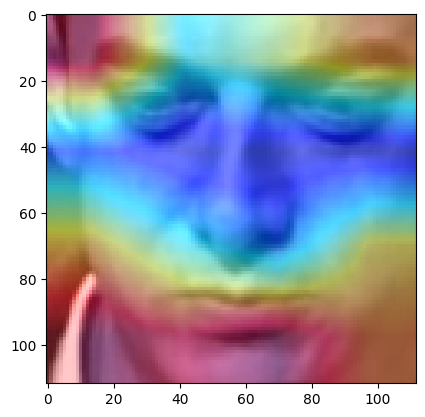

Original label: None, Predicted label: REAL


In [15]:
import os
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
def get_videos_from_folder(folder_path, video_extensions=[".mp4", ".avi", ".mkv"]):
    video_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if any(file.endswith(ext) for ext in video_extensions):
                video_files.append(os.path.join(root, file))
    return video_files

# Define the path to the folder containing the videos
video_folder_path = "./Test"

# Get all the videos from the folder
path_to_videos = get_videos_from_folder(video_folder_path)

# # Use the validation_dataset with the list of videos
path_to_model = r"C:\Users\KK\Desktop\dfd\checkpoint2.pt"
model = Model(2).cuda()
# model = torch.load(path_to_model)  # Load the checkpoint file

model.load_state_dict(torch.load(path_to_model))
model.eval()


# Define path to CSV for labels
csv_path = r'C:\Users\KK\Desktop\dfd\test\metadata.csv'

# video_folder_path = r"C:\Users\KK\Desktop\dfd\Celeb-DF\test"
# path_to_videos = get_videos_from_folder(video_folder_path)
path_to_videos = [r"C:\Users\KK\Desktop\dfd\Celeb-DF\Celeb-real\id0_0002.mp4"]

video_dataset = validation_dataset(path_to_videos, csv_path=csv_path, sequence_length=20, transform=train_transforms)

# Process all videos
for i in range(len(path_to_videos)):
    print(f"Processing video: {path_to_videos[i]}")
    
    # Get frames and original label
    frames, original_label = video_dataset[i]
    
    # Make prediction
    prediction = predict(model, frames, './')
    
    # Print original and predicted labels
    print(f"Original label: {original_label}, Predicted label: {'REAL' if prediction[0] == 1 else 'FAKE'}")


usage: ipykernel_launcher.py [-h] --model_path MODEL_PATH --input INPUT [--output_dir OUTPUT_DIR] [--face_extraction]
                             [--visualization] [--sequence_length SEQUENCE_LENGTH]
ipykernel_launcher.py: error: the following arguments are required: --model_path, --input


SystemExit: 2

C:\Users\KK\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
